# K-近邻算法

**k-Nearest Neighbors**

**Pros:** High accuracy, insensitive to outliers, no assumptions about data 

**Cons:** Computationally expensive, requires a lot of memory

**Works with:** Numeric values, nominal values

## 约会网站预测

### 初始数据处理

**原始数据集在当前文件夹datingTestSet.txt文件里,其格式如下**:
- Feature1:More ActionsNumber of frequent flyer miles earned per year
- Feature2:Percentage of time spent playing video games
- Feature3:Liters of ice cream consumed per week
- Classify: 分类结果

| Feature1 | Feature2 | Feature3 | Classify   |
| -------- | -------- | -------- | ---------- |
| 40920    | 8.326976 | 0.953952 | largeDoses |

初始数据有一些问题，我们需要进行处理后才能使用：

1. 因为我们计算距离是用的欧式距离，但初始初始的每个Feature的大小不一致，所以要进行归一化处理，使每个Feature的权重都类似
2. Classify的结果用的是largeDoses等字符串表示，我们最好把它换成数字标签

#### 初始数据读取，保存到numpy数组

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
test = np.zeros((3,2))
test

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [3]:
test[1]=(1,1)
test

array([[0., 0.],
       [1., 1.],
       [0., 0.]])

In [4]:
def file_matric(file):
    """该函数把文件数据解析，返回numpy数组"""
    label_vetor = {'largeDoses':3,
                   'smallDoses':2,
                   'didntLike':1}
    fr = open(file, encoding='utf-8')
    numberoflines = len(fr.readlines())
    returnMat = np.zeros((numberoflines, 3))
    classlabels = []
    
    fr = open(file, encoding='utf-8')
    
    index = 0
    for line in fr.readlines():
        line = line.strip()
        listfromline = line.split('\t')
        #print(listfromline)
        returnMat[index] = listfromline[:3]
        classlabels.append(label_vetor[listfromline[-1]])
        index +=1
        
    return returnMat, classlabels

In [5]:
feature_matic, class_lables = file_matric('datingTestSet.txt')

In [6]:
feature_matic

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [7]:
class_lables[:5]

[3, 2, 1, 1, 1]

##### 可视化读取到的数据

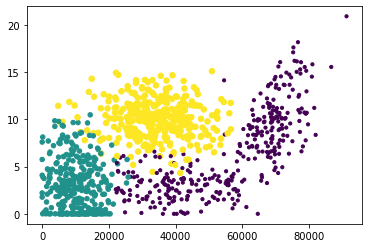

In [8]:
plt.scatter(feature_matic[:,0], feature_matic[:, 1], 10*np.array(class_lables), 10*np.array(class_lables))#第3,4个参数根据label来区别大小颜色

In [9]:
import matplotlib
print(matplotlib.__version__)

3.1.1


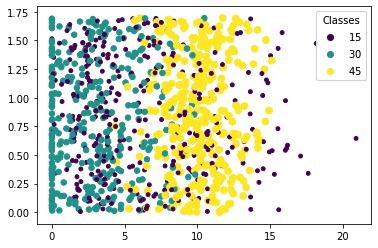

In [9]:
fig, ax = plt.subplots()
scatter = ax.scatter(feature_matic[:,1], feature_matic[:,2], 15*np.array(class_lables), 15*np.array(class_lables))#第3,4个参数根据label来区别大小颜色
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Classes")
ax.add_artist(legend1)

#### 归一化处理

- 差值 = 最大值-最小值
- 归一化数据 = 当前值/差值

In [10]:
np.set_printoptions(suppress=True)
feature_matic[:10]

array([[40920.      ,     8.326976,     0.953952],
       [14488.      ,     7.153469,     1.673904],
       [26052.      ,     1.441871,     0.805124],
       [75136.      ,    13.147394,     0.428964],
       [38344.      ,     1.669788,     0.134296],
       [72993.      ,    10.14174 ,     1.032955],
       [35948.      ,     6.830792,     1.213192],
       [42666.      ,    13.276369,     0.54388 ],
       [67497.      ,     8.631577,     0.749278],
       [35483.      ,    12.273169,     1.508053]])

In [11]:
def autonorm(dataset):
    """该函数用于归一化所有特征,返回归一化后的特征以及每个特征的跨度长度"""
    overlength = dataset.max(0) - dataset.min(0) #np.amax(dataset, 0)
    return dataset/overlength ,overlength

In [12]:
normalmat ,overlength = autonorm(feature_matic)

In [37]:
overlength

array([91273.      ,    20.919349,     1.694361])

In [38]:
normalmat[:4]

array([[0.44832535, 0.39805139, 0.56301579],
       [0.15873259, 0.34195467, 0.98792642],
       [0.28542943, 0.06892523, 0.47517855],
       [0.82320073, 0.62848007, 0.25317155]])

### 分类预测模型

#### 分类预测函数

In [42]:
ss = np.zeros((3,2)) + np.ones(2)
ss

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [45]:
ss.sum(axis=1)

array([2., 2., 2.])

In [46]:
ss = [2,2,2,1,3,4]

In [47]:
from collections import Counter

In [48]:
ss = Counter(ss)
ss

Counter({2: 3, 1: 1, 3: 1, 4: 1})

In [50]:
sorted(ss.items(), key=lambda x: x[1], reverse=True)

[(2, 3), (1, 1), (3, 1), (4, 1)]

In [126]:
from collections import Counter
def classify0(inx, dataset, lable, k):
    """
    inx    : 预测输入值， inx也是归一化后的数据
    dataset: 归一化后的特征数组
    label  ：特征所属分类
    k      ：KNN算法中的k值，即最靠近的k个元素
    """
    #print(inx)
    #print(dataset)
    #print(lable)
    
    diffmat = dataset - inx #有自动广播功能所以可以直接相减
    sqdiff = diffmat**2
    diastances = sqdiff.sum(axis =1)
    sortedindex = diastances.argsort()#排序后返回索引值列表距离从近到远
    
    classCount = []
    for i in range(k):
        classCount.append(lable[sortedindex[i]])
    result = Counter(classCount)
    
    result_lable = sorted(result.items(), key=lambda x: x[1],reverse=True)
    return result_lable[0][0]
    

In [127]:
classify0(np.array([0.5,0.5,0.5]), normalmat, class_lables, 5)

3

#### 测试分类模型的准确率

In [71]:
def class_test_accuracy():
    """该函数测试模型的准确率"""
    ratio = 0.2 #要测试的数据量,从原始数据中取
    feature_matic, class_lables = file_matric('datingTestSet.txt')
    nomalMat , overlength = autonorm(feature_matic)
    testlength = int(ratio* len(class_lables))
    
    testmat = nomalMat[:testlength]
    
    errorcount = 0
    for i in range(testlength):
        result = classify0(testmat[i,:], nomalMat, class_lables, 5)
        print('The calssifier came back with :%d, the real answer is %d'%(class_lables[i], result))
        
        if int(class_lables[i]) != int(result):
            errorcount += 1
    
    print("The total error rate is : %f"% (errorcount/testlength))
        
    

In [70]:
class_test_accuracy()

The calssifier came back with :3, the real answer is 3
The calssifier came back with :2, the real answer is 2
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :3, the real answer is 3
The calssifier came back with :3, the real answer is 3
The calssifier came back with :1, the real answer is 1
The calssifier came back with :3, the real answer is 3
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :2, the real answer is 2
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssifier came back with :1, the real answer is 1
The calssi

### 最终模型

In [205]:
from collections import Counter
import numpy as np
class Knn_Classifying:  
    def __init__(self, data_file_path):
        self.data_file_path = data_file_path
        self.data_matric, self.class_label = self.__file_matric()
        self.data_normed, self.overlength = self.__autonorm()
        
    def __file_matric(self):
        """该函数把文件数据解析，返回numpy数组"""
        #label_vetor = {'largeDoses':3,
        #               'smallDoses':2,
        #               'didntLike':1}
        with open(self.data_file_path, encoding='utf-8') as fr:
            one_line_str = fr.readline()
            one_line_str = one_line_str.strip()
            listfromline = one_line_str.split('\t')
            
            num_of_feature = len(listfromline) -1
            numberoflines = len(fr.readlines())+1
            returnMat = np.zeros((numberoflines, num_of_feature))
            classlabels = []

        with open(self.data_file_path, encoding='utf-8') as fr:
            index = 0
            for line in fr.readlines():
                line = line.strip()
                listfromline = line.split('\t')
                #print(listfromline)
                returnMat[index] = listfromline[:num_of_feature]
                classlabels.append(listfromline[-1])
                index +=1
            
        return returnMat, classlabels

    def __autonorm(self):
        """该函数用于归一化所有特征,返回归一化后的特征以及每个特征的跨度长度"""
        overlength = self.data_matric.max(0) - self.data_matric.min(0) #np.amax(dataset, 0)
        return self.data_matric/overlength ,overlength
    
    def __classify0(self, inx, k):
        """
        inx    : 预测输入值， inx也是归一化后的数据
        k      ：KNN算法中的k值，即最靠近的k个元素
        """
        #print(inx)
        #print(dataset)
        #print(lable)

        diffmat = self.data_normed - inx #有自动广播功能所以可以直接相减
        sqdiff = diffmat**2
        diastances = sqdiff.sum(axis =1)
        sortedindex = diastances.argsort()#排序后返回索引值列表距离从近到远

        classCount = []
        for i in range(k):
            classCount.append(self.class_label[sortedindex[i]])
        result = Counter(classCount)

        result_lable = sorted(result.items(), key=lambda x: x[1],reverse=True)
        return result_lable[0][0]

    def class_test_accuracy(self, ratio):
        """该函数测试模型的准确率"""
        #ratio = 0.2 #要测试的数据量,从原始数据中取
        testlength = int(ratio* len(self.data_matric))
        testmat = self.data_normed[:testlength]

        errorcount = 0
        for i in range(testlength):
            result = self.__classify0(testmat[i,:], 5)
            print('The calssifier came back with :{}, the real answer is {}'.format(self.class_label[i], result))

            if self.class_label[i].strip() != result.strip():
                errorcount += 1 
        print("The total error rate is : %f"% (errorcount/testlength))
        
    def class_dating(self, inx, k):
        """输入一个特征,输出预测结果"""
        #resultlist = ['not at all', 'in samll doses', 'in large doses']
        inx = np.array(inx)
        result = self.__classify0(inx / self.overlength, k)
        print('You probably like this person '+ result)

In [206]:
my_date = Knn_Classifying('datingTestSet.txt')

In [209]:
my_date.class_dating([10000,10,0.5], 5)

You probably like this person smallDoses


In [208]:
my_date.data_normed

array([[0.44832535, 0.39805139, 0.56301579],
       [0.15873259, 0.34195467, 0.98792642],
       [0.28542943, 0.06892523, 0.47517855],
       ...,
       [0.29115949, 0.50910294, 0.51147719],
       [0.52711097, 0.43665451, 0.42968706],
       [0.47940793, 0.3768091 , 0.7864003 ]])

## 手写输入预测

### 初始数据处理

We’ll be working only with the digits 0–9

test vectors like piture show below

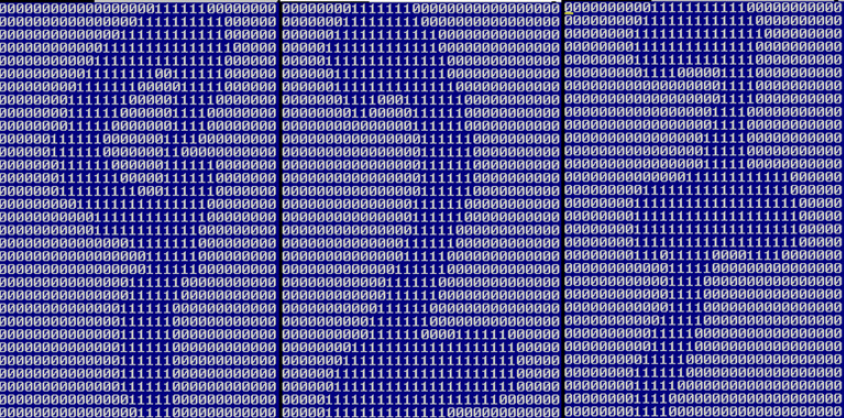

数字向量由1x1024 个0|1 组成 每一个0|1都当作一个特征值

文件在当前文件夹testDigits目录下,每个数字都有多个不同手写文档

In [81]:
#!dir testDigits

In [89]:
ss = np.zeros(5)
ss

array([0., 0., 0., 0., 0.])

In [105]:
def imag_array(filename):
    "读取一个文件的特征,返回数组"
    returnVect = np.zeros(1024)
    with open(filename) as f:
        for i in range(32): #已经确定每个文件有32行数据
            linestr = f.readline()
            for j in range(32):
                returnVect[i*32+j] = int(linestr[j])
    
    return returnVect          

In [106]:
ss = imag_array('testDigits/1_0.txt')

In [107]:
trainmatric = np.zeros((3, 1024))

In [109]:
trainmatric[1,:] = ss
trainmatric

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 分类预测模型

#### 分类预测函数

In [111]:
import os

In [113]:
#os.listdir('testDigits')

In [128]:
import os
def class_handwrite(inputfile, trainfile):
    """从trainfile文件夹中获取所有特征，和对应类别，并针对inputfile文件进行预测"""
    hwlable = []
    trainingfilelist = os.listdir(trainfile)
    m = len(trainingfilelist)
    trainmatric = np.zeros((m, 1024))
    for i, filename in enumerate(trainingfilelist):
        trainmatric[i,:] = imag_array(trainfile + "/" +filename)
        hwlable.append(int(filename.split('_')[0]))
        
    inputdata = imag_array(inputfile)
    
    #距离计算然后预测类别可以直接用之前的分类函数
    result = classify0(inputdata, trainmatric, hwlable, 5)
    
    return result

In [131]:
class_handwrite('testDigits/2_1.txt','testDigits')

2

#### 测试分类模型的准确率

In [140]:
def class_handwrite_accuracy():
    """该函数测试模型的准确率"""
    trainfile  = 'testDigits'
    
    ratio = 0.1
    
    hwlable = []
    trainingfilelist = os.listdir(trainfile)
    m = len(trainingfilelist)
    trainmatric = np.zeros((m, 1024))
    for i, filename in enumerate(trainingfilelist):
        trainmatric[i,:] = imag_array(trainfile + "/" +filename)
        hwlable.append(int(filename.split('_')[0]))
          
    errorcount = 0 
    
    num_to_test = int(m*ratio)
    for i in range(num_to_test):           
        result = classify0(trainmatric[i,:], trainmatric, hwlable, 5)
        correctnum = int(trainingfilelist[i].split('_')[0])
        print('the classifer came back with :%d, the correct num is : %d'% (correctnum, result))
        if correctnum != result:
            errorcount += 1
    
    print("the error rate is %.4f" %(errorcount/ num_to_test))

In [76]:
#class_handwrite_accuracy()

### 最终模型

In [95]:
import os 
import numpy as np
class Hand_Write_knn:
    def __init__(self, train_file_path):
        self.train_file_path = train_file_path
        self.data_matric, self.class_label = self.__data_pre_deal()
        
    def __imag_array(self, filename):
        "读取一个文件的特征,返回数组"
        returnVect = np.zeros(1024)
        with open(filename) as f:
            for i in range(32): #已经确定每个文件有32行数据
                linestr = f.readline()
                for j in range(32):
                    returnVect[i*32+j] = int(linestr[j])

        return returnVect 
    
    def __data_pre_deal(self):
        """从trainfile文件夹中获取所有特征，和对应类别，并针对inputfile文件进行预测"""
        hwlable = []
        trainingfilelist = os.listdir(self.train_file_path)
        m = len(trainingfilelist)
        trainmatric = np.zeros((m, 1024))
        for i, filename in enumerate(trainingfilelist):
            trainmatric[i,:] = self.__imag_array(os.path.join(self.train_file_path, filename))
            hwlable.append(int(filename.split('_')[0]))
        return trainmatric, hwlable

    def __classify0(self, inx, k):
        """
        inx    : 预测输入值， inx也是归一化后的数据
        k      ：KNN算法中的k值，即最靠近的k个元素
        """
        #print(inx)
        #print(dataset)
        #print(lable)

        diffmat = self.data_matric - inx #有自动广播功能所以可以直接相减
        sqdiff = diffmat**2
        diastances = sqdiff.sum(axis =1)
        sortedindex = diastances.argsort()#排序后返回索引值列表距离从近到远

        classCount = []
        for i in range(k):
            classCount.append(self.class_label[sortedindex[i]])
        result = Counter(classCount)

        result_lable = sorted(result.items(), key=lambda x: x[1],reverse=True)
        return result_lable[0][0]
    
    def class_handwrite_accuracy(self, ratio):
        """该函数测试模型的准确率"""

        trainingfilelist = os.listdir(self.train_file_path)
        m = len(trainingfilelist)

        errorcount = 0 

        num_to_test = int(m*ratio)
        for i in range(num_to_test):           
            result = self.__classify0(self.data_matric[i,:], 5)
            correctnum = int(trainingfilelist[i].split('_')[0])
            print('the classifer came back with :{}, the correct num is : {}'.format(result, correctnum))
            if correctnum != result:
                errorcount += 1
        print("the error rate is %.4f" %(errorcount/ num_to_test))
    
    def class_handwrite(self, predict_file, k):
        """从trainfile文件夹中获取所有特征，和对应类别，并针对inputfile文件进行预测"""

        inputdata = self.__imag_array(predict_file)
        
        result = self.__classify0(inputdata, k)
        return result

In [96]:
path = r'E:\MYGIT\Self-learning\Machine Learning In Action\Ch01\testDigits'
my_handwrite = Hand_Write_knn(path)

In [99]:
path = r'E:\MYGIT\Self-learning\Machine Learning In Action\Ch01\testDigits\9_22.txt'
my_handwrite.class_handwrite(path, 5)

9

In [100]:
import sys

In [101]:
sys.getsizeof(my_handwrite)

56

In [102]:
sys.getsizeof(Hand_Write_knn)

1056

In [138]:
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

In [136]:
y = np.sin(X).ravel()


array([ 0.09381086,  0.65695022,  0.81553704,  0.40518094,  0.08102512,
       -0.26432971, -0.72911815, -0.99643995])

# 利用sklearn模块进行knn分类预测

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors, datasets

In [210]:
label_dict = {3: 'largeDoses',
              2: 'smallDoses',
              1: 'didntLike'}

def file_matric(file):
    """该函数把文件数据解析，返回numpy数组"""
    label_vetor = {'largeDoses':3,
                   'smallDoses':2,
                   'didntLike':1}
    fr = open(file, encoding='utf-8')
    numberoflines = len(fr.readlines())
    returnMat = np.zeros((numberoflines, 3))
    classlabels = []
    
    fr = open(file, encoding='utf-8')
    
    index = 0
    for line in fr.readlines():
        line = line.strip()
        listfromline = line.split('\t')
        #print(listfromline)
        returnMat[index] = listfromline[:3]
        classlabels.append(label_vetor[listfromline[-1]])
        index +=1
        
    return returnMat, np.array(classlabels)

In [249]:
X,y = file_matric('datingTestSet.txt')
ss = MinMaxScaler()
X_normed = ss.fit_transform(X) #归一化

In [250]:
clf = neighbors.KNeighborsClassifier(5, algorithm= 'brute',weights = 'uniform')
clf.fit(X_normed,y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [251]:
new_X = np.vstack((X,np.array([[10000,10,0.5]])))
new_X = ss.fit_transform(new_X) #归一化
input_x = new_X[-1]
input_x = np.expand_dims(input_x, axis=0)
tt = clf.predict(input_x)
print(label_dict[tt[0]])

smallDoses


In [253]:
input_x

array([[0.10956143, 0.47802635, 0.29441424]])